In [1]:
#generativeimage2text.
from generativeimage2text.common import Config
from generativeimage2text.common import get_mpi_rank, get_mpi_size, get_mpi_local_rank
import json
import os.path as op
from generativeimage2text.common import qd_tqdm as tqdm
from generativeimage2text.common import json_dump
from generativeimage2text.common import pilimg_from_base64
from generativeimage2text.torch_common import recursive_to_device
from generativeimage2text.tsv_io import TSVFile, tsv_writer, tsv_reader, load_from_yaml_file
from generativeimage2text.common import write_to_file
import torch
import PIL
from pprint import pformat
import logging
from transformers import BertTokenizer
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
#from azfuse import File

from generativeimage2text.common import dict_update_path_value, dict_get_path_value, get_all_path, load_from_yaml_str
from generativeimage2text.common import init_logging
from generativeimage2text.common import parse_general_args
from generativeimage2text.torch_common import torch_load
from generativeimage2text.torch_common import load_state_dict
from generativeimage2text.torch_common import resize_2d_pos_embed
from generativeimage2text.layers.CLIP import clip
from generativeimage2text.layers.decoder import (TransformerDecoderTextualHead,
                             AutoRegressiveBeamSearch, GeneratorWithBeamSearch)
from generativeimage2text.layers.decoder import CaptioningModel
from generativeimage2text.process_image import load_image_by_pil
from generativeimage2text.data_layer.builder import collate_fn
from generativeimage2text.train import get_data, get_image_transform as get_image_transform_GIT
from generativeimage2text.inference import MinMaxResizeForTest, get_image_transform
from tqdm import tqdm as tqm
from generativeimage2text.model import get_git_model
import numpy as np
import pandas as pd

In [2]:
torch.cuda.empty_cache()


### Training the COCO Model


In [3]:
# import pandas as pd
# def checkdata_vallidation():
#     lang_codes = ['hau', 'kir','tha']
#     #lang_codes = ['kir']
#     for code in lang_codes:
#         list_images = os.listdir('../images_{}'.format(code))
#         for phase in ['train', 'validation', 'test']:
#             df = pd.read_csv("../{}_{}_dataframe.csv".format(code, phase))
#             for img in tqm([x[1] for x in df['image_path'].str.split('/')]):
#                 if img not in list_images:
#                     print(code+' '+phase+' '+img+ ' not exist!')
#                     break
#     print('complete')

# checkdata_vallidation()

In [4]:
import os
import pandas as pd
target_language = ['tha'] #  ['hau','kir', 'tha']

train_dataset = map(pd.read_csv, [f"../{lang}_train_dataframe.csv" for lang in target_language])
train = pd.concat(train_dataset, axis=0, ignore_index=True)
train['image_path'] = train['image_path'].apply(lambda x : '../'+x)

val_dataset = map(pd.read_csv, [f"../{lang}_validation_dataframe.csv" for lang in target_language])
val = pd.concat(val_dataset, axis=0, ignore_index=True)
val['image_path'] = val['image_path'].apply(lambda x : '../'+x)

test_dataset = map(pd.read_csv, [f"../{lang}_test_dataframe.csv" for lang in target_language])
test = pd.concat(test_dataset, axis=0, ignore_index=True)
test['image_path'] = test['image_path'].apply(lambda x : '../'+x)

images_train = train.image_path.values
captions_train = train.English.values

images_val= val.image_path.values
captions_val = val.English.values

prefixs = None

In [5]:
# build transforms
cfg = {
    'crop_region_extend_in_datatransform': 4,
    'data_normalize': 'clip',
    'train_crop_size': 224,
    'input_small_scale': 0.8,
    'no_color_jitter': True,
    'no_flip': True,
    'no_aspect_dist': True,
    'interpolation': 'bicubic',
    'min_size_range32': [160, 224], # in pretraining, it is multi-scale from 160 to 224; while for fine-tuning, it is single scale
    'patch_size': 16,
    'train_transform': 'vitp',
}
cfg = Config(cfg, {})
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
image_transform = get_image_transform_GIT(cfg)


C:\Users\zwdua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\transforms\transforms.py:899: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [6]:
# prepossessing data
torch.cuda.empty_cache()


def fill_batches(images, captions, batch_size):
    length = len(images)
    if length%batch_size != 0:
        idx = np.random.choice(np.arange(length - length%batch_size), batch_size - length%batch_size, replace=False)
        return np.concatenate((images[idx],images)), np.concatenate((captions[idx],captions))
    else:
        return images, captions

# prepare training dataset
batch_size = 14
images_train, captions_train = fill_batches(images_train, captions_train, batch_size)

data_train = []
batch = []
num = 0

prefixs = [''] * len(captions_train)
print(f'Training dataset {len(images_train)}')
for image_file, prefix, target in tqm(zip(images_train, prefixs, captions_train)):
    #print(image_file, prefix, target)
    data = get_data(image_file, prefix, target,
                    tokenizer, image_transform)
    num += 1
    batch.append(data)
    if num%batch_size == 0:
        
        data_train.append(batch)
        batch = []

# record from where is val batches        
tran_val_position = len(data_train)

num = 0
batch = []
prefixs = [''] * len(captions_val)
print(f'Validation dataset {len(images_val)}')
for image_file, prefix, target in tqm(zip(images_val, prefixs, captions_val)):
    #print(image_file, prefix, target)
    data = get_data(image_file, prefix, target,
                    tokenizer, image_transform)
    num += 1
    batch.append(data)
    if num%batch_size == 0:
        
        data_train.append(batch)
        batch = []
if batch:
    data_train.append(batch)

data_train = [collate_fn(x) for x in data_train]
data_train = recursive_to_device(data_train, 'cuda')



Training dataset 2912


2912it [03:29, 13.89it/s]


Validation dataset 52


52it [00:01, 30.05it/s]


In [7]:
# load model
param  = {}
model = get_git_model(tokenizer, param)
pretrained = 'BASE_COCO_checkpoint.pt'
loaded_checkpoint = torch_load(pretrained)
checkpoint = loaded_checkpoint['model']
load_state_dict(model, checkpoint)
model.train()
model.cuda();

C:\Users\zwdua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [8]:
#len(data_train), tran_val_position

In [9]:
import time
import copy
lr = 1e-6
gamma=0.9
opt = torch.optim.Adam(model.parameters(), lr =lr)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=gamma)

In [10]:
# training the model
torch.cuda.empty_cache()
epochs = 1
iteration =0
patient = 5

train_batch_loss = []
train_loss = []
val_loss = []
start = time.time()

# save best model
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 1e6
best_epoch = 0

for epoch in range(epochs):
    
    train_epoch_losses = []
    val_epoch_losses = []
    val_batch_num = 0
    print(f"epoch {epoch} \n")
    for i, batch in enumerate(data_train):
       
        if i < tran_val_position:
            # the batch use now is for training
            opt.zero_grad() # 
            loss_dict = model(batch)
            loss = sum(loss_dict.values())
            loss.backward()
            opt.step()
            train_epoch_losses.append(loss.item())
            train_batch_loss.append(loss.item())
            iteration += 1
            
            print(f"    Iter {iteration}: loss: {loss}")
        #print(f"epoch {epoch}: loss: {sum(losses)/len(losses)}")
        else:
            
            # batch for validation
            # Set model to evaluate mode

            opt.zero_grad()
            #with torch.inference_mode():               
            loss_dict = model(batch)
            loss = sum(loss_dict.values())
            
            loss.backward()
            val_epoch_losses.append(loss.item())
            
            val_batch_num += 1
            
            #print(f"    Val batch  {val_batch_num}: loss: {loss}")
    val_batch_avgLoss = sum(val_epoch_losses)/len(val_epoch_losses) if len(val_epoch_losses) != 0 else 0
    train_batch_avgLoss = sum(train_epoch_losses)/len(train_epoch_losses)
    val_loss.append(val_batch_avgLoss)
    train_loss.append(train_batch_avgLoss)
    scheduler.step()
    if val_batch_avgLoss < best_loss:
        best_loss = val_batch_avgLoss
        best_model_wts = copy.deepcopy(model.state_dict())
        best_epoch = epoch
        stop_num =0
    else:
        stop_num += 1
    
    if stop_num>=patient:
        break
        
    print(f"  training loss: {train_batch_avgLoss},\
                            validation loss: {val_batch_avgLoss}")
end = time.time()

epoch 0 

    Iter 1: loss: 5.231799125671387
    Iter 2: loss: 5.5500407218933105
    Iter 3: loss: 5.230072021484375
    Iter 4: loss: 5.4163818359375
    Iter 5: loss: 5.0238118171691895
    Iter 6: loss: 5.5654778480529785
    Iter 7: loss: 4.498833656311035
    Iter 8: loss: 5.394659996032715
    Iter 9: loss: 5.138285160064697
    Iter 10: loss: 4.507847309112549
    Iter 11: loss: 5.2450337409973145
    Iter 12: loss: 4.553411960601807
    Iter 13: loss: 5.143592834472656
    Iter 14: loss: 4.809286594390869
    Iter 15: loss: 4.9017510414123535
    Iter 16: loss: 4.959351539611816
    Iter 17: loss: 4.381208419799805
    Iter 18: loss: 4.571835517883301
    Iter 19: loss: 4.65532112121582
    Iter 20: loss: 4.979959011077881
    Iter 21: loss: 4.534088611602783
    Iter 22: loss: 4.876745223999023
    Iter 23: loss: 5.391257286071777
    Iter 24: loss: 4.59967565536499
    Iter 25: loss: 4.92580509185791
    Iter 26: loss: 4.543792724609375
    Iter 27: loss: 5.309393882751465


In [13]:
#torch.cuda.is_available()

In [14]:
PATH = "hau-finetuned-checkpoint_final.pt"

torch.save({'lr' : lr,
            'gamma' : gamma,
            'epoch': epoch,
            'batch_size': batch_size,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss':train_loss,
            'val_loss':val_loss
            }, PATH)


In [11]:
PATH = "tha-finetuned-checkpoint_best1.pt"

torch.save({'lr' : lr,
            'gamma' : gamma,
            'epoch': best_epoch,
            'batch_size': batch_size,
            'model_state_dict': best_model_wts,
            'optimizer_state_dict': opt.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
             'train_loss':train_loss,
            'val_loss':val_loss
            }, PATH)

### Inference on  Images

In [3]:
# # tokenizer, prepossessing
# param = {}
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# # transforms
# transforms = get_image_transform(param)

# # load model
# model = get_git_model(tokenizer, param)
# pretrained = 'BASE_COCO_checkpoint.pt'
# loaded_checkpoint = torch_load(pretrained)
# checkpoint = loaded_checkpoint['model']
# load_state_dict(model, checkpoint)

# # evaluate mode
# model.eval()
# torch.cuda.set_device(get_mpi_local_rank())
# model.cuda()


In [5]:
data = pd.read_csv('../test.csv')
data = data[data['ISO639-3'] == 'kir']
data = data.reset_index(drop = True)
data

,Id,ImageURL,ISO639-3,Path
0,0293a8c7-b69e-4c58-8caf-4a58e17bbacb_kir,https://bloom-vist.s3.amazonaws.com/%D0%A6%D0%...,kir,image_test/0293a8c7-b69e-4c58-8caf-4a58e17bbac...
1,04a00291-ef0f-4bb5-8b37-75d300ceffaf_kir,https://bloom-vist.s3.amazonaws.com/%D0%9C%D0%...,kir,image_test/04a00291-ef0f-4bb5-8b37-75d300ceffa...
2,0da41c23-0b28-46ba-853c-bbef07dfbbbc_kir,https://bloom-vist.s3.amazonaws.com/%D0%A1%D1%...,kir,image_test/0da41c23-0b28-46ba-853c-bbef07dfbbb...
3,0de1bb36-93b8-4457-9570-33b72827c2f0_kir,https://bloom-vist.s3.amazonaws.com/%D0%9A%D3%...,kir,image_test/0de1bb36-93b8-4457-9570-33b72827c2f...
4,0df6e791-2aab-4a7d-8c87-077cdc47c674_kir,https://bloom-vist.s3.amazonaws.com/%D0%9C%D0%...,kir,image_test/0df6e791-2aab-4a7d-8c87-077cdc47c67...
...,...,...,...,...
62,06d4f633-edcd-46b5-bd83-f6d349cb5445_kir,https://bloom-vist.s3.amazonaws.com/test/testk...,kir,image_test/06d4f633-edcd-46b5-bd83-f6d349cb544...
63,d8f01179-768f-4272-8309-b1bbf34188be_kir,https://bloom-vist.s3.amazonaws.com/test/testk...,kir,image_test/d8f01179-768f-4272-8309-b1bbf34188b...
64,e0331a04-0515-45db-8295-b8d4055f14c2_kir,https://bloom-vist.s3.amazonaws.com/test/testk...,kir,image_test/e0331a04-0515-45db-8295-b8d4055f14c...
65,20b040af-6cc2-4f62-b6ef-52f05e7559a8_kir,https://bloom-vist.s3.amazonaws.com/test/testk...,kir,image_test/20b040af-6cc2-4f62-b6ef-52f05e7559a...


In [85]:
hau = pd.read_csv('../kir_validation_dataframe.csv')
hau = hau.iloc[[3],:]
hau

,image_id,image_url,caption,story_id,album_id,license,original_bloom_language_tag,index_in_story,image_path,English
3,a0f8ad11-fdf9-4753-8ebf-9f1dd9190e11,https://bloom-vist.s3.amazonaws.com/%D0%A3%D0%...,– Сен бир кызыктай жөжө экенсиң! Биз сени мене...,a3669526-494b-4d6c-b3a3-5f744a46ed2e,f600fc2a-e715-471a-b42a-b09bc9205ca1,cc-by-nc,ky,3,images_kir/d737ad87-9e8c-4527-8a7b-7c88832f644...,- You are a strange little boy! We will not pl...


In [86]:
hau['caption'].values, hau['English'].values,

(array(['– Сен бир кызыктай жөжө экенсиң! Биз сени менен экинчи ойнобойбуз!\xa0– деп айтып, кетип калышты.'],
       dtype=object),
 array(['- You are a strange little boy! We will not play with you again! - they said and left.'],
       dtype=object))

In [87]:
image_path = ['../'+x for x in hau['image_path'].values]


In [96]:
# tokenizer, prepossessing
param = {}
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# transforms
transforms = get_image_transform(param)

# load model

model = get_git_model(tokenizer, param)
# pretrained = '../TrainedModel/hau-finetuned-checkpoint_best.pt'
# loaded_checkpoint = torch_load(pretrained)
finetuneModel = torch.load('kir-finetuned-checkpoint_final.pt')
model.load_state_dict(finetuneModel['model_state_dict'])

# evaluate mode
model.eval()
torch.cuda.set_device(get_mpi_local_rank())
model.cuda();

In [93]:
finetuneModel.keys()

dict_keys(['lr', 'gamma', 'epoch', 'batch_size', 'model_state_dict', 'optimizer_state_dict', 'scheduler_state_dict', 'train_loss', 'val_loss'])

In [97]:
finetuneModel['train_loss']

[3.966517637112389,
 3.5359901189804077,
 3.258497467801615,
 3.031702443865911,
 2.830238574121627,
 2.6406819549806277,
 2.45328255957621,
 2.2844356927403644,
 2.13612606902064,
 1.995205142381001,
 1.8593896353171646,
 1.7190394908006936,
 1.601827605096109,
 1.495072537496046]

In [98]:
finetuneModel['val_loss']

[3.761474847793579,
 3.6779261112213133,
 3.6856510162353517,
 3.6381295204162596,
 3.690618896484375,
 3.729967737197876,
 3.794285297393799,
 3.820425605773926,
 3.895233392715454,
 3.9396831035614013,
 3.949754238128662,
 4.000078201293945,
 4.067960166931153,
 4.110282039642334]

In [89]:
# define your image paths here
#image_path = ['aux_data/images/1.jpg', 'aux_data/images/009dd2f8-5ba2-4ab0-93ba-4f15869e4d5d.jpg', 'aux_data/images/00f3aaf2-d1d7-4ea7-829d-00f83db4fca1.jpg']
#image_path = ['aux_data/images/00f3aaf2-d1d7-4ea7-829d-00f83db4fca1.jpg']
image_path = ['../'+x for x in hau['image_path'].values]

if isinstance(image_path, str):
    image_path = [image_path]
# if it is more than 1 image, it is normally a video with multiple image
# frames
img = [load_image_by_pil(i) for i in image_path]

#transforms = get_image_transform(param)
img = [transforms(i) for i in img]
img = [i.unsqueeze(0).cuda() for i in img]
prefix = ''
# prefix
max_text_len = 50
prefix_encoding = tokenizer(prefix,
                            padding='do_not_pad',
                            
                            truncation=True,
                            add_special_tokens=False,
                            max_length=max_text_len)
payload = prefix_encoding['input_ids']
if len(payload) > max_text_len - 2:
    payload = payload[-(max_text_len - 2):]
input_ids = [tokenizer.cls_token_id] + payload

with torch.no_grad():
    results = [model({
        'image': image,
        'prefix': torch.tensor(input_ids).unsqueeze(0).cuda(),
    }) for image in tqm(img)]
cap = [tokenizer.decode(result['predictions'][0].tolist(), skip_special_tokens=True) for result in results]

for i in cap:
    print(i)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.50s/it]

the ducks are very happy.


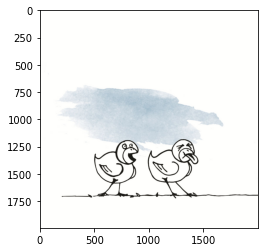

In [88]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(image_path[0])
imgplot = plt.imshow(img)

### Inference on tsv file

In [2]:
# tokenizer, prepossessing
param = {}
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# transforms
image_transform = get_image_transform(param)

# load model

model = get_git_model(tokenizer, param)
# pretrained = '../TrainedModel/hau-finetuned-checkpoint_best.pt'
# loaded_checkpoint = torch_load(pretrained)
finetuneModel = torch.load('tha-finetuned-checkpoint_best1.pt')
model.load_state_dict(finetuneModel['model_state_dict'])

# evaluate mode
model.eval()
torch.cuda.set_device(get_mpi_local_rank())
model.cuda();

C:\Users\zwdua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\transforms\transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [3]:
image_tsv = 'aux_data/images/test_tha.tsv'
image_tsv = TSVFile(image_tsv)
out_tsv = 'output/test_tha_output1.tsv'

In [4]:
from generativeimage2text.tsv_io import concat_tsv_files, save_file
# prefix
max_text_len = 50
rank = get_mpi_rank()
world_size = get_mpi_size()
def get_rank_specific_tsv(rank):
    return '{}.{}.{}.tsv'.format(out_tsv, rank, world_size)
if world_size > 1:
    curr_out_tsv = get_rank_specific_tsv(rank)
else:
    curr_out_tsv = out_tsv
total = len(image_tsv)
curr_size = (total + world_size - 1) // world_size
curr_start = curr_size * rank
curr_end = curr_start + curr_size
curr_end = min(curr_end, total)


def gen_rows():
    for i  in tqdm(range(curr_start, curr_end)):
        key, col = image_tsv[i]
        img = pilimg_from_base64(col)
        img = image_transform(img)
        img = img.cuda().unsqueeze(0)
        with torch.no_grad():
            result = model({
                'image': img,
            })
            # changes here
        cap = tokenizer.decode(result['predictions'][0].tolist(), skip_special_tokens=True)
        

        yield key, json_dump(cap)
# Ziv changed
#tsv_writer(gen_rows(), curr_out_tsv)
save_file(gen_rows(), curr_out_tsv)

if world_size > 1 and rank == 0:
    all_sub_tsv = [get_rank_specific_tsv(i) for i in range(world_size)]
    while True:
        not_ready = [t for t in all_sub_tsv if not File.isfile(t)]
        if len(not_ready) == 0:
            break
        else:
            import time
            logging.info('waiting {}'.format(','.join(not_ready)))
            time.sleep(5)
    
    concat_tsv_files(all_sub_tsv, out_tsv)


tsv_io.py:384: 0it [00:00, ?it/s]
tsv_io.py:384: 1it [00:29, 29.93s/it]                                                           | 0/69 [00:00<?, ?it/s]
2519841281.py:20:   1%|▉                                                                | 1/69 [00:29<33:52, 29.89s/it]

tsv_io.py:384: 2it [00:59, 30.00s/it]
2519841281.py:20:   3%|█▉                                                               | 2/69 [00:59<33:28, 29.98s/it]

tsv_io.py:384: 3it [01:40, 34.87s/it]
2519841281.py:20:   4%|██▊                                                              | 3/69 [01:40<38:20, 34.86s/it]

tsv_io.py:384: 4it [02:04, 30.42s/it]
2519841281.py:20:   6%|███▊                                                             | 4/69 [02:04<32:57, 30.42s/it]

tsv_io.py:384: 5it [02:31, 29.33s/it]
2519841281.py:20:   7%|████▋                                                            | 5/69 [02:31<31:16, 29.32s/it]

tsv_io.py:384: 6it [02:41, 22.67s/it]
2519841281.py:20:   9%|█████▋                                                           | 6/69 [02:41<23:47, 22.66s/it]

tsv_io.py:384: 7it [04:03, 42.00s/it]
2519841281.py:20:  10%|██████▌                                                          | 7/69 [04:03<43:23, 42.00s/it]

tsv_io.py:384: 8it [04:56, 45.66s/it]
2519841281.py:20:  12%|███████▌                                                         | 8/69 [04:56<46:25, 45.66s/it]

tsv_io.py:384: 9it [05:47, 47.13s/it]
2519841281.py:20:  13%|████████▍                                                        | 9/69 [05:46<47:07, 47.13s/it]

tsv_io.py:384: 10it [06:28, 45.26s/it]
2519841281.py:20:  14%|█████████▎                                                      | 10/69 [06:28<44:30, 45.26s/it]

tsv_io.py:384: 11it [07:43, 54.39s/it]
2519841281.py:20:  16%|██████████▏                                                     | 11/69 [07:43<52:34, 54.39s/it]

tsv_io.py:384: 12it [08:12, 46.61s/it]
2519841281.py:20:  17%|███████████▏                                                    | 12/69 [08:11<44:16, 46.61s/it]

tsv_io.py:384: 13it [08:52, 44.67s/it]
2519841281.py:20:  19%|████████████                                                    | 13/69 [08:52<41:41, 44.67s/it]

tsv_io.py:384: 14it [10:00, 51.67s/it]
2519841281.py:20:  20%|████████████▉                                                   | 14/69 [10:00<47:21, 51.67s/it]

tsv_io.py:384: 15it [10:42, 48.91s/it]
2519841281.py:20:  22%|█████████████▉                                                  | 15/69 [10:42<44:01, 48.91s/it]

tsv_io.py:384: 16it [10:46, 35.30s/it]
2519841281.py:20:  23%|██████████████▊                                                 | 16/69 [10:46<31:11, 35.30s/it]

tsv_io.py:384: 17it [11:28, 37.34s/it]
2519841281.py:20:  25%|███████████████▊                                                | 17/69 [11:28<32:21, 37.34s/it]

tsv_io.py:384: 18it [12:14, 40.02s/it]
2519841281.py:20:  26%|████████████████▋                                               | 18/69 [12:14<34:01, 40.02s/it]

tsv_io.py:384: 19it [13:17, 46.86s/it]
2519841281.py:20:  28%|█████████████████▌                                              | 19/69 [13:17<39:02, 46.86s/it]

tsv_io.py:384: 20it [14:30, 54.73s/it]
2519841281.py:20:  29%|██████████████████▌                                             | 20/69 [14:30<44:41, 54.73s/it]

tsv_io.py:384: 21it [15:44, 60.62s/it]
2519841281.py:20:  30%|███████████████████▍                                            | 21/69 [15:44<48:29, 60.62s/it]

tsv_io.py:384: 22it [16:24, 54.32s/it]
2519841281.py:20:  32%|████████████████████▍                                           | 22/69 [16:24<42:33, 54.32s/it]

tsv_io.py:384: 23it [17:43, 61.87s/it]
2519841281.py:20:  33%|█████████████████████▎                                          | 23/69 [17:43<47:25, 61.87s/it]

tsv_io.py:384: 24it [18:43, 61.11s/it]
2519841281.py:20:  35%|██████████████████████▎                                         | 24/69 [18:43<45:49, 61.11s/it]

tsv_io.py:384: 25it [19:37, 58.92s/it]
2519841281.py:20:  36%|███████████████████████▏                                        | 25/69 [19:37<43:12, 58.92s/it]

tsv_io.py:384: 26it [20:45, 61.91s/it]
2519841281.py:20:  38%|████████████████████████                                        | 26/69 [20:45<44:22, 61.91s/it]

tsv_io.py:384: 27it [21:41, 60.04s/it]
2519841281.py:20:  39%|█████████████████████████                                       | 27/69 [21:41<42:01, 60.04s/it]

tsv_io.py:384: 28it [22:11, 51.02s/it]
2519841281.py:20:  41%|█████████████████████████▉                                      | 28/69 [22:11<34:51, 51.02s/it]

tsv_io.py:384: 29it [23:19, 55.96s/it]
2519841281.py:20:  42%|██████████████████████████▉                                     | 29/69 [23:19<37:18, 55.96s/it]

tsv_io.py:384: 30it [24:00, 51.65s/it]
2519841281.py:20:  43%|███████████████████████████▊                                    | 30/69 [24:00<33:34, 51.65s/it]

tsv_io.py:384: 31it [24:25, 43.51s/it]
2519841281.py:20:  45%|████████████████████████████▊                                   | 31/69 [24:25<27:33, 43.51s/it]

tsv_io.py:384: 32it [25:07, 43.08s/it]
2519841281.py:20:  46%|█████████████████████████████▋                                  | 32/69 [25:07<26:34, 43.08s/it]

tsv_io.py:384: 33it [25:27, 36.36s/it]
2519841281.py:20:  48%|██████████████████████████████▌                                 | 33/69 [25:27<21:48, 36.36s/it]

tsv_io.py:384: 34it [26:19, 40.97s/it]
2519841281.py:20:  49%|███████████████████████████████▌                                | 34/69 [26:19<23:54, 40.97s/it]

tsv_io.py:384: 35it [26:54, 39.20s/it]
2519841281.py:20:  51%|████████████████████████████████▍                               | 35/69 [26:54<22:12, 39.20s/it]

tsv_io.py:384: 36it [27:12, 32.84s/it]
2519841281.py:20:  52%|█████████████████████████████████▍                              | 36/69 [27:12<18:03, 32.84s/it]

tsv_io.py:384: 37it [28:44, 50.52s/it]
2519841281.py:20:  54%|██████████████████████████████████▎                             | 37/69 [28:44<26:56, 50.52s/it]

tsv_io.py:384: 38it [28:52, 37.80s/it]
2519841281.py:20:  55%|███████████████████████████████████▏                            | 38/69 [28:52<19:31, 37.80s/it]

tsv_io.py:384: 39it [29:59, 46.52s/it]
2519841281.py:20:  57%|████████████████████████████████████▏                           | 39/69 [29:59<23:15, 46.52s/it]

tsv_io.py:384: 40it [31:00, 50.85s/it]
2519841281.py:20:  58%|█████████████████████████████████████                           | 40/69 [31:00<24:34, 50.85s/it]

tsv_io.py:384: 41it [31:37, 46.77s/it]
2519841281.py:20:  59%|██████████████████████████████████████                          | 41/69 [31:37<21:49, 46.77s/it]

tsv_io.py:384: 42it [32:06, 41.26s/it]
2519841281.py:20:  61%|██████████████████████████████████████▉                         | 42/69 [32:06<18:34, 41.26s/it]

tsv_io.py:384: 43it [32:47, 41.29s/it]
2519841281.py:20:  62%|███████████████████████████████████████▉                        | 43/69 [32:47<17:53, 41.29s/it]

tsv_io.py:384: 44it [33:35, 43.23s/it]
2519841281.py:20:  64%|████████████████████████████████████████▊                       | 44/69 [33:35<18:00, 43.23s/it]

tsv_io.py:384: 45it [34:51, 53.02s/it]
2519841281.py:20:  65%|█████████████████████████████████████████▋                      | 45/69 [34:51<21:12, 53.02s/it]

tsv_io.py:384: 46it [35:00, 39.88s/it]
2519841281.py:20:  67%|██████████████████████████████████████████▋                     | 46/69 [35:00<15:17, 39.88s/it]

tsv_io.py:384: 47it [35:44, 41.04s/it]
2519841281.py:20:  68%|███████████████████████████████████████████▌                    | 47/69 [35:44<15:02, 41.04s/it]

tsv_io.py:384: 48it [36:28, 41.94s/it]
2519841281.py:20:  70%|████████████████████████████████████████████▌                   | 48/69 [36:28<14:40, 41.94s/it]

tsv_io.py:384: 49it [37:15, 43.70s/it]
2519841281.py:20:  71%|█████████████████████████████████████████████▍                  | 49/69 [37:15<14:33, 43.70s/it]

tsv_io.py:384: 50it [38:20, 49.87s/it]
2519841281.py:20:  72%|██████████████████████████████████████████████▍                 | 50/69 [38:20<15:47, 49.87s/it]

tsv_io.py:384: 51it [38:39, 40.60s/it]
2519841281.py:20:  74%|███████████████████████████████████████████████▎                | 51/69 [38:39<12:10, 40.60s/it]

tsv_io.py:384: 52it [39:07, 36.87s/it]
2519841281.py:20:  75%|████████████████████████████████████████████████▏               | 52/69 [39:07<10:26, 36.87s/it]

tsv_io.py:384: 53it [39:26, 31.58s/it]
2519841281.py:20:  77%|█████████████████████████████████████████████████▏              | 53/69 [39:26<08:25, 31.58s/it]

tsv_io.py:384: 54it [39:48, 28.67s/it]
2519841281.py:20:  78%|██████████████████████████████████████████████████              | 54/69 [39:48<07:10, 28.67s/it]

tsv_io.py:384: 55it [40:45, 37.17s/it]
2519841281.py:20:  80%|███████████████████████████████████████████████████             | 55/69 [40:45<08:40, 37.17s/it]

tsv_io.py:384: 56it [41:43, 43.40s/it]
2519841281.py:20:  81%|███████████████████████████████████████████████████▉            | 56/69 [41:43<09:24, 43.40s/it]

tsv_io.py:384: 57it [42:33, 45.47s/it]
2519841281.py:20:  83%|████████████████████████████████████████████████████▊           | 57/69 [42:33<09:05, 45.47s/it]

tsv_io.py:384: 58it [43:01, 40.04s/it]
2519841281.py:20:  84%|█████████████████████████████████████████████████████▊          | 58/69 [43:01<07:20, 40.04s/it]

tsv_io.py:384: 59it [43:06, 29.54s/it]
2519841281.py:20:  86%|██████████████████████████████████████████████████████▋         | 59/69 [43:06<04:55, 29.54s/it]

tsv_io.py:384: 60it [43:45, 32.58s/it]
2519841281.py:20:  87%|███████████████████████████████████████████████████████▋        | 60/69 [43:45<04:53, 32.58s/it]

tsv_io.py:384: 61it [43:54, 25.46s/it]
2519841281.py:20:  88%|████████████████████████████████████████████████████████▌       | 61/69 [43:54<03:23, 25.46s/it]

tsv_io.py:384: 62it [44:00, 19.74s/it]
2519841281.py:20:  90%|█████████████████████████████████████████████████████████▌      | 62/69 [44:00<02:18, 19.74s/it]

tsv_io.py:384: 63it [44:27, 21.72s/it]
2519841281.py:20:  91%|██████████████████████████████████████████████████████████▍     | 63/69 [44:27<02:10, 21.72s/it]

tsv_io.py:384: 64it [44:40, 19.14s/it]
2519841281.py:20:  93%|███████████████████████████████████████████████████████████▎    | 64/69 [44:40<01:35, 19.14s/it]

tsv_io.py:384: 65it [44:55, 17.83s/it]
2519841281.py:20:  94%|████████████████████████████████████████████████████████████▎   | 65/69 [44:55<01:11, 17.83s/it]

tsv_io.py:384: 66it [45:13, 17.96s/it]
2519841281.py:20:  96%|█████████████████████████████████████████████████████████████▏  | 66/69 [45:13<00:53, 17.96s/it]

tsv_io.py:384: 67it [45:28, 17.12s/it]
2519841281.py:20:  97%|██████████████████████████████████████████████████████████████▏ | 67/69 [45:28<00:34, 17.12s/it]

tsv_io.py:384: 68it [45:31, 12.71s/it]
2519841281.py:20:  99%|███████████████████████████████████████████████████████████████ | 68/69 [45:31<00:12, 12.71s/it]

tsv_io.py:384: 69it [45:49, 14.31s/it]
2519841281.py:20: 100%|████████████████████████████████████████████████████████████████| 69/69 [45:49<00:00, 39.84s/it]
tsv_io.py:384: 69it [45:49, 39.84s/it]